# Gaussian Line Emulator

This notebook demonstrates a simple Gaussian line emulator as an alternative to TransformerPayne. The emulator uses a blackbody continuum with Gaussian absorption lines.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)

In [2]:
from typing import Any, Dict, List
from functools import partial
import jax
from jax.typing import ArrayLike

# Physical constants
h = 6.62607015e-27  # Planck's constant [erg*s]
c = 2.99792458e10   # Speed of light [cm/s]
k = 1.380649e-16    # Boltzmann constant [erg/K]


## GaussianLineEmulator Class

This class implements a spectrum emulator that:
- Uses a blackbody continuum based on temperature
- Applies Gaussian absorption lines at specified wavelengths
- Is compatible with SPICE's mesh models


In [6]:
class GaussianLineEmulator:
    """A simple spectrum emulator with Gaussian absorption lines.
    
    This emulator creates spectra with a blackbody continuum and Gaussian
    absorption lines. It can be used as a drop-in replacement for more
    complex emulators like TransformerPayne for testing and demonstration.
    
    Parameters:
        line_centers: List of wavelengths (Angstroms) for line centers
        line_widths: List of line widths (Angstroms) for each line
        line_depths: List of line depths (0-1) for each line
    """
    
    def __init__(self, 
                 line_centers: List[float] = None,
                 line_widths: List[float] = None,
                 line_depths: List[float] = None):
        
        # Default: single line at 5500 Angstroms
        self.line_centers = jnp.array(line_centers if line_centers else [5500.0])
        self.line_widths = jnp.array(line_widths if line_widths else [0.5])
        self.line_depths = jnp.array(line_depths if line_depths else [0.3])
        
        if len(self.line_centers) != len(self.line_widths) or \
           len(self.line_centers) != len(self.line_depths):
            raise ValueError("line_centers, line_widths, and line_depths must have the same length")
    
    @property
    def parameter_names(self) -> List[str]:
        """Get labels of spectrum model parameters"""
        return ["Teff"]
    
    @property
    def stellar_parameter_names(self) -> List[str]:
        """Get labels of stellar parameters (for compatibility)"""
        return self.parameter_names
    
    @property
    def solar_parameters(self) -> ArrayLike:
        """Solar parameters for the spectrum model"""
        return jnp.array([5777.0])  # Solar temperature
    
    def to_parameters(self, parameter_values: Dict[str, Any] = None) -> ArrayLike:
        """Convert passed values to the accepted parameters format
        
        Args:
            parameter_values: Dictionary with parameter values {'Teff': value}
            
        Returns:
            Array of parameters [Teff]
        """
        if not parameter_values:
            return self.solar_parameters
        
        Teff = parameter_values.get('Teff', self.solar_parameters[0])
        return jnp.array([Teff])
    
    def intensity(self, log_wavelengths: ArrayLike, mu: float, 
                  spectral_parameters: ArrayLike) -> ArrayLike:
        """Calculate the intensity for given wavelengths and mu
        
        Args:
            log_wavelengths: log10 of wavelengths in Angstroms
            mu: cosine of angle between surface normal and line of sight
            spectral_parameters: Array of parameters [Teff]
            
        Returns:
            Array of shape (n_wavelengths, 2) with:
                [:, 0]: intensity with absorption lines
                [:, 1]: continuum intensity (no lines)
        """
        return _gaussian_line_intensity(
            log_wavelengths, mu, spectral_parameters,
            self.line_centers, self.line_widths, self.line_depths
        )
    
    def flux(self, log_wavelengths: ArrayLike, spectral_parameters: ArrayLike,
             mus_number: int = 20) -> ArrayLike:
        """Compute the flux by integrating intensity over the stellar disk
        
        Args:
            log_wavelengths: log10 of wavelengths in Angstroms
            spectral_parameters: Array of parameters [Teff]
            mus_number: Number of mu points for Gaussian quadrature
            
        Returns:
            Array of fluxes
        """
        roots, weights = np.polynomial.legendre.leggauss(mus_number)
        roots = (roots + 1) / 2
        weights /= 2
        return _flux(tuple(roots), tuple(weights), self.intensity,
                    log_wavelengths, spectral_parameters)


In [7]:
def _blackbody(wavelength_cm: ArrayLike, T: float) -> ArrayLike:
    """Planck function for blackbody radiation
    
    Args:
        wavelength_cm: Wavelength in cm
        T: Temperature in Kelvin
        
    Returns:
        Intensity in erg/s/cm^2/steradian/cm
    """
    return 2 * h * c**2 / wavelength_cm**5 / (jnp.exp(h * c / (wavelength_cm * k * T)) - 1)


@jax.jit
def _gaussian_line_intensity(log_wavelengths: ArrayLike, mu: float,
                            spectral_parameters: ArrayLike,
                            line_centers: ArrayLike,
                            line_widths: ArrayLike,
                            line_depths: ArrayLike) -> ArrayLike:
    """Calculate intensity with Gaussian absorption lines
    
    Args:
        log_wavelengths: log10 of wavelengths in Angstroms
        mu: cosine of angle (not used for blackbody, but kept for interface)
        spectral_parameters: [Teff]
        line_centers: Center wavelengths for lines (Angstroms)
        line_widths: Widths (sigma) for Gaussian lines (Angstroms)
        line_depths: Depths of lines (0 = no line, 1 = complete absorption)
        
    Returns:
        Intensity array with shape (n_wavelengths, 2)
    """
    # Convert log wavelengths to cm
    wavelengths_angstrom = 10 ** log_wavelengths
    wavelengths_cm = wavelengths_angstrom * 1e-8
    
    # Extract temperature
    Teff = spectral_parameters[0]
    
    # Calculate blackbody continuum
    continuum = _blackbody(wavelengths_cm, Teff)
    
    # Convert to per-Angstrom units
    continuum = continuum * 1e-8
    
    # Apply Gaussian absorption lines
    absorption = jnp.ones_like(wavelengths_angstrom)
    
    for i in range(len(line_centers)):
        # Gaussian profile: depth * exp(-(lambda - lambda0)^2 / (2*sigma^2))
        gaussian = jnp.exp(-0.5 * ((wavelengths_angstrom - line_centers[i]) / line_widths[i])**2)
        absorption = absorption * (1 - line_depths[i] * gaussian)
    
    # Apply absorption to continuum
    intensity_with_lines = continuum * absorption
    
    # Stack results: [intensity with lines, continuum]
    result = jnp.stack([intensity_with_lines, continuum], axis=1)
    
    # Handle any NaN values
    result = jnp.where(jnp.isnan(result), 0.0, result)
    
    return result


@partial(jax.jit, static_argnums=(0, 1, 2))
def _flux(roots: tuple, weights: tuple, intensity_method: callable,
          log_wavelengths: ArrayLike, spectral_parameters: ArrayLike) -> ArrayLike:
    """Integrate intensity over stellar disk using Gaussian quadrature"""
    roots, weights = jnp.array(roots), jnp.array(weights)
    return 2 * jnp.pi * jnp.sum(
        jax.vmap(intensity_method, in_axes=(None, 0, None))(
            log_wavelengths, roots, spectral_parameters
        ) * roots[:, jnp.newaxis, jnp.newaxis] * weights[:, jnp.newaxis, jnp.newaxis],
        axis=0
    )


## Basic Usage: Single Line

Let's create a simple emulator with a single absorption line and visualize the spectrum.


In [8]:
# Create emulator with a single line at 5500 Angstroms
emulator = GaussianLineEmulator(
    line_centers=[5500.0],
    line_widths=[0.5],      # Width in Angstroms
    line_depths=[0.4]       # 40% absorption depth
)

# Set stellar parameters
params = emulator.to_parameters({'Teff': 5777.0})  # Solar temperature

# Generate wavelength grid
wavelengths = jnp.linspace(5000, 6000, 10000)
log_wavelengths = jnp.log10(wavelengths)

# Calculate intensity at mu = 1 (disk center)
intensity = emulator.intensity(log_wavelengths, mu=1.0, spectral_parameters=params)

print(f"Intensity shape: {intensity.shape}")
print(f"Parameter names: {emulator.stellar_parameter_names}")
print(f"Parameters: {params}")


Intensity shape: (10000, 2)
Parameter names: ['Teff']
Parameters: [5777.]


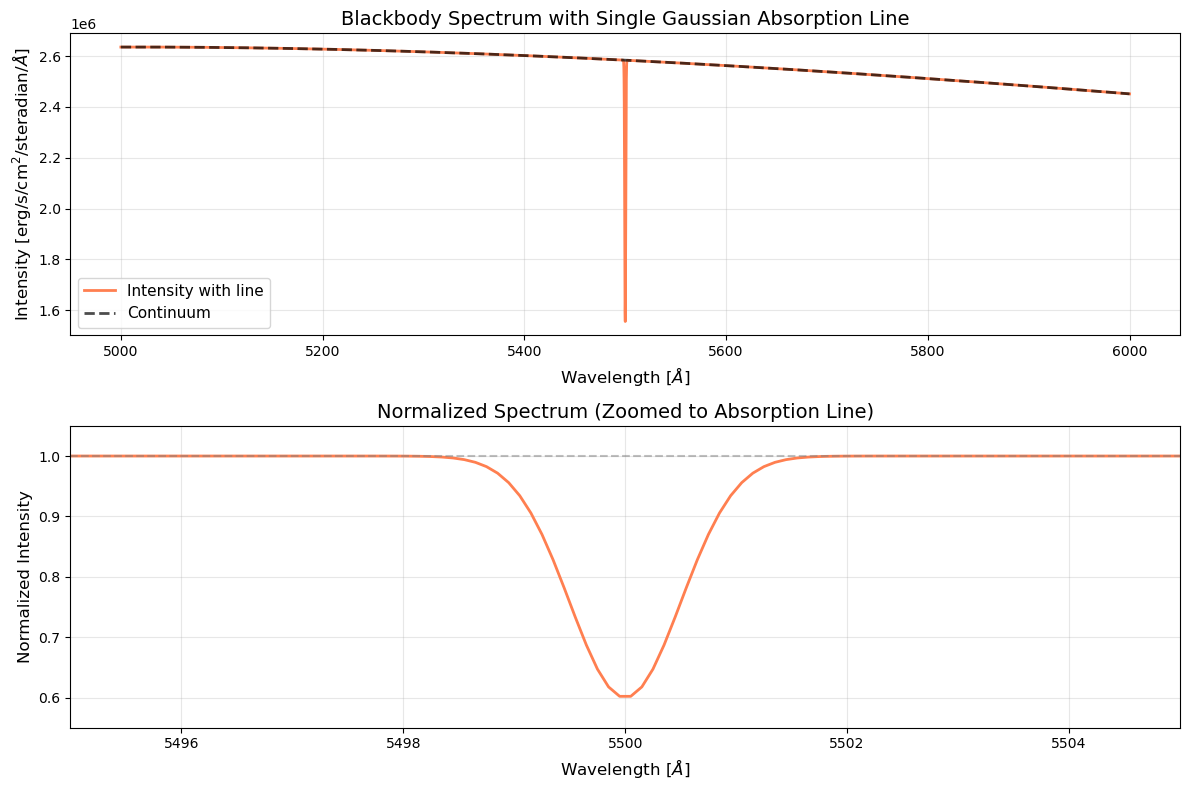

In [9]:
# Plot the spectrum
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

# Top panel: Full spectrum
ax1.plot(wavelengths, intensity[:, 0], label='Intensity with line', color='coral', linewidth=2)
ax1.plot(wavelengths, intensity[:, 1], label='Continuum', color='black', 
         linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax1.set_ylabel('Intensity [erg/s/cm$^2$/steradian/$\AA$]', fontsize=12)
ax1.set_title('Blackbody Spectrum with Single Gaussian Absorption Line', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Bottom panel: Normalized spectrum (zoomed to line)
normalized = intensity[:, 0] / intensity[:, 1]
ax2.plot(wavelengths, normalized, label='Normalized intensity', color='coral', linewidth=2)
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax2.set_ylabel('Normalized Intensity', fontsize=12)
ax2.set_title('Normalized Spectrum (Zoomed to Absorption Line)', fontsize=14)
ax2.set_xlim(5495, 5505)
ax2.set_ylim(0.55, 1.05)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Multiple Absorption Lines

Now let's create an emulator with multiple absorption lines at different wavelengths, mimicking realistic stellar spectra.


In [10]:
# Create emulator with multiple lines
emulator_multi = GaussianLineEmulator(
    line_centers=[5000.0, 5300.0, 5500.0, 5700.0, 5900.0],
    line_widths=[0.3, 0.5, 0.4, 0.6, 0.35],
    line_depths=[0.3, 0.5, 0.4, 0.35, 0.45]
)

# Generate spectrum
params_multi = emulator_multi.to_parameters({'Teff': 6000.0})
wavelengths_multi = jnp.linspace(4800, 6100, 20000)
intensity_multi = emulator_multi.intensity(
    jnp.log10(wavelengths_multi), mu=1.0, spectral_parameters=params_multi
)


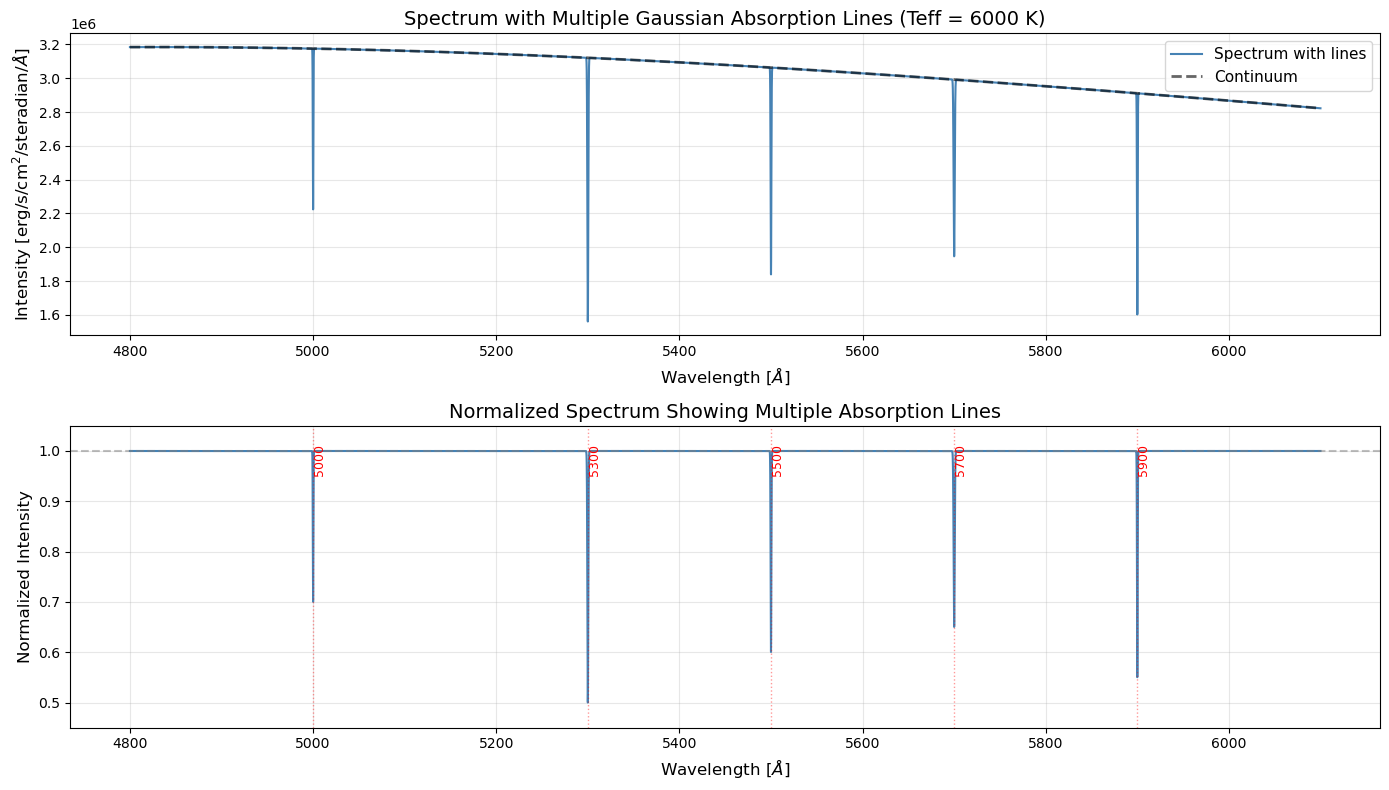

In [11]:
# Plot multiple lines
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8))

# Full spectrum
ax1.plot(wavelengths_multi, intensity_multi[:, 0], label='Spectrum with lines', 
         color='steelblue', linewidth=1.5)
ax1.plot(wavelengths_multi, intensity_multi[:, 1], label='Continuum', 
         color='black', linestyle='--', linewidth=2, alpha=0.6)
ax1.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax1.set_ylabel('Intensity [erg/s/cm$^2$/steradian/$\AA$]', fontsize=12)
ax1.set_title('Spectrum with Multiple Gaussian Absorption Lines (Teff = 6000 K)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Normalized spectrum
normalized_multi = intensity_multi[:, 0] / intensity_multi[:, 1]
ax2.plot(wavelengths_multi, normalized_multi, color='steelblue', linewidth=1.5)
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5)

# Mark line centers
for center in emulator_multi.line_centers:
    ax2.axvline(center, color='red', linestyle=':', alpha=0.4, linewidth=1)
    ax2.text(center, 0.95, f'{center:.0f}', rotation=90, 
             verticalalignment='bottom', fontsize=9, color='red')

ax2.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax2.set_ylabel('Normalized Intensity', fontsize=12)
ax2.set_title('Normalized Spectrum Showing Multiple Absorption Lines', fontsize=14)
ax2.set_ylim(0.45, 1.05)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Temperature Effects

Let's see how the spectrum changes with different stellar temperatures.


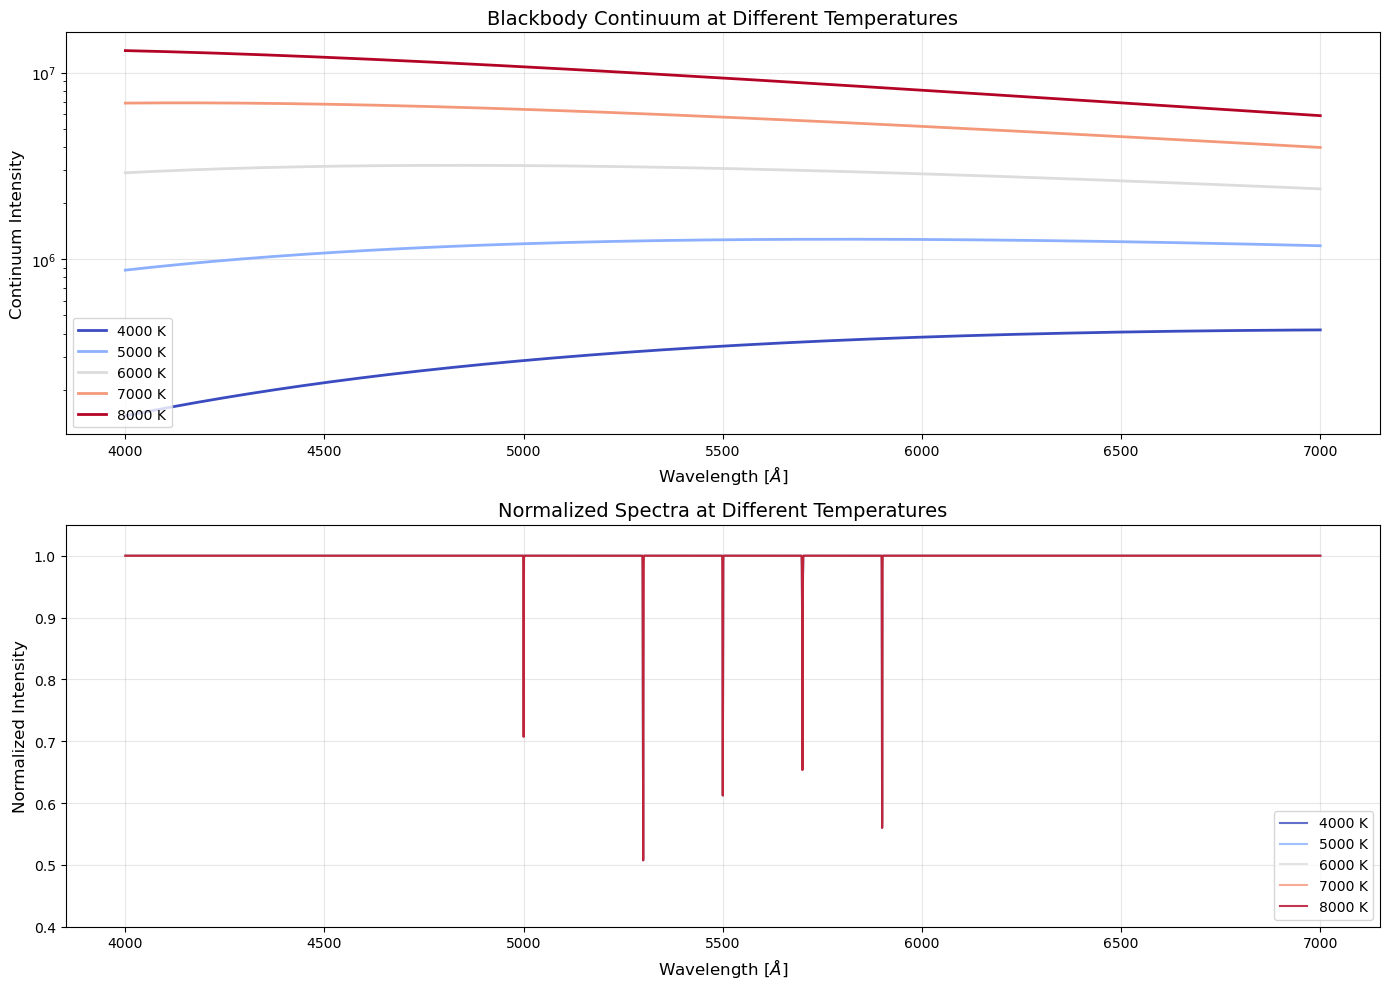

In [12]:
# Compare different temperatures
temperatures = [4000, 5000, 6000, 7000, 8000]
wavelengths_temp = jnp.linspace(4000, 7000, 15000)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 10))

# Use a colormap
colors = plt.cm.coolwarm(np.linspace(0, 1, len(temperatures)))

for i, temp in enumerate(temperatures):
    params_temp = emulator_multi.to_parameters({'Teff': temp})
    intensity_temp = emulator_multi.intensity(
        jnp.log10(wavelengths_temp), mu=1.0, spectral_parameters=params_temp
    )
    
    # Continuum
    ax1.plot(wavelengths_temp, intensity_temp[:, 1], 
             label=f'{temp} K', color=colors[i], linewidth=2)
    
    # Normalized spectrum
    normalized_temp = intensity_temp[:, 0] / intensity_temp[:, 1]
    ax2.plot(wavelengths_temp, normalized_temp, 
             label=f'{temp} K', color=colors[i], linewidth=1.5, alpha=0.8)

ax1.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax1.set_ylabel('Continuum Intensity', fontsize=12)
ax1.set_title('Blackbody Continuum at Different Temperatures', fontsize=14)
ax1.legend(fontsize=10)
ax1.set_yscale('log')
ax1.grid(alpha=0.3)

ax2.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax2.set_ylabel('Normalized Intensity', fontsize=12)
ax2.set_title('Normalized Spectra at Different Temperatures', fontsize=14)
ax2.legend(fontsize=10, loc='lower right')
ax2.set_ylim(0.4, 1.05)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Integration with SPICE Mesh Models

Now let's integrate the Gaussian line emulator with SPICE's mesh models to create a rotating star.


In [13]:
# Import SPICE modules
import sys
sys.path.insert(0, '../../src')

from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.spectrum.spectrum import simulate_observed_flux


In [14]:
# Create a rotating star model
emulator_star = GaussianLineEmulator(
    line_centers=[5500.0],
    line_widths=[0.3],
    line_depths=[0.5]
)

# Create mesh model
mesh_resolution = 1000  # Number of mesh elements
stellar_radius = 1.0    # Solar radii
stellar_mass = 1.0      # Solar masses

# Create base model
params_star = emulator_star.to_parameters({'Teff': 5777.0})
base_model = IcosphereModel.construct(
    mesh_resolution,
    stellar_radius,
    stellar_mass,
    params_star,
    emulator_star.stellar_parameter_names
)

print(f"Created mesh model with {mesh_resolution} elements")
print(f"Stellar parameters: {params_star}")


/Users/mjablons/Documents/stellar-mesh-integration/tutorial/paper_results/../../src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Created mesh model with 1000 elements
Stellar parameters: [5777.]


In [15]:
# Add rotation to the model
v_rot = 50.0  # km/s
rotation_axis = jnp.array([0., 0., 1.])  # Rotate around z-axis

# Create rotating model
rotating_model = add_rotation(base_model, v_rot, rotation_axis)

# Evaluate at a specific rotation phase
phase = 0.0
evaluated_model = evaluate_rotation(rotating_model, phase)

print(f"Rotation velocity: {v_rot} km/s")
print(f"Model evaluated at phase: {phase}")


Rotation velocity: 50.0 km/s
Model evaluated at phase: 0.0


In [16]:
# Generate spectrum for non-rotating and rotating star
wavelengths_rot = jnp.linspace(5496, 5504, 2000)
log_wavelengths_rot = jnp.log10(wavelengths_rot)

# Non-rotating spectrum
spec_no_rot = simulate_observed_flux(
    emulator_star.intensity, base_model, log_wavelengths_rot
)

# Rotating spectrum
spec_rot = simulate_observed_flux(
    emulator_star.intensity, evaluated_model, log_wavelengths_rot
)

print(f"Non-rotating spectrum shape: {spec_no_rot.shape}")
print(f"Rotating spectrum shape: {spec_rot.shape}")


Non-rotating spectrum shape: (2000, 2)
Rotating spectrum shape: (2000, 2)


In [18]:
import matplotlib
%matplotlib inline

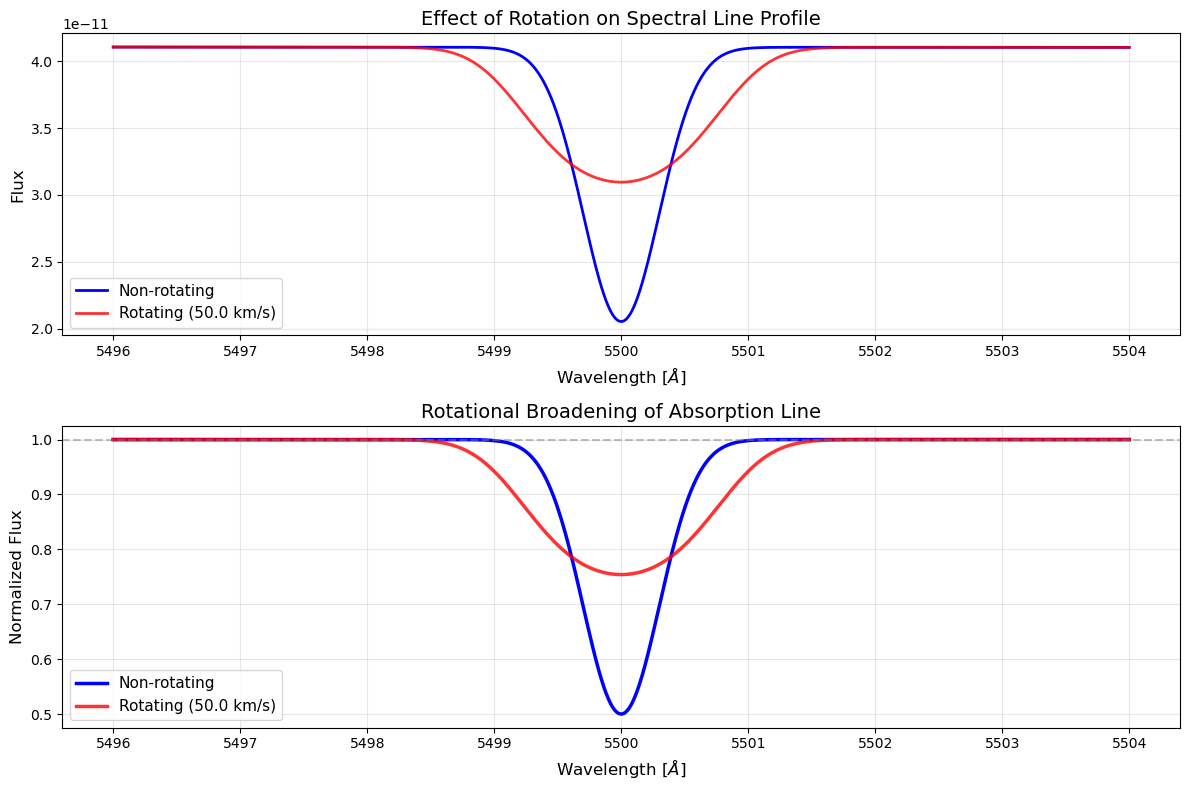

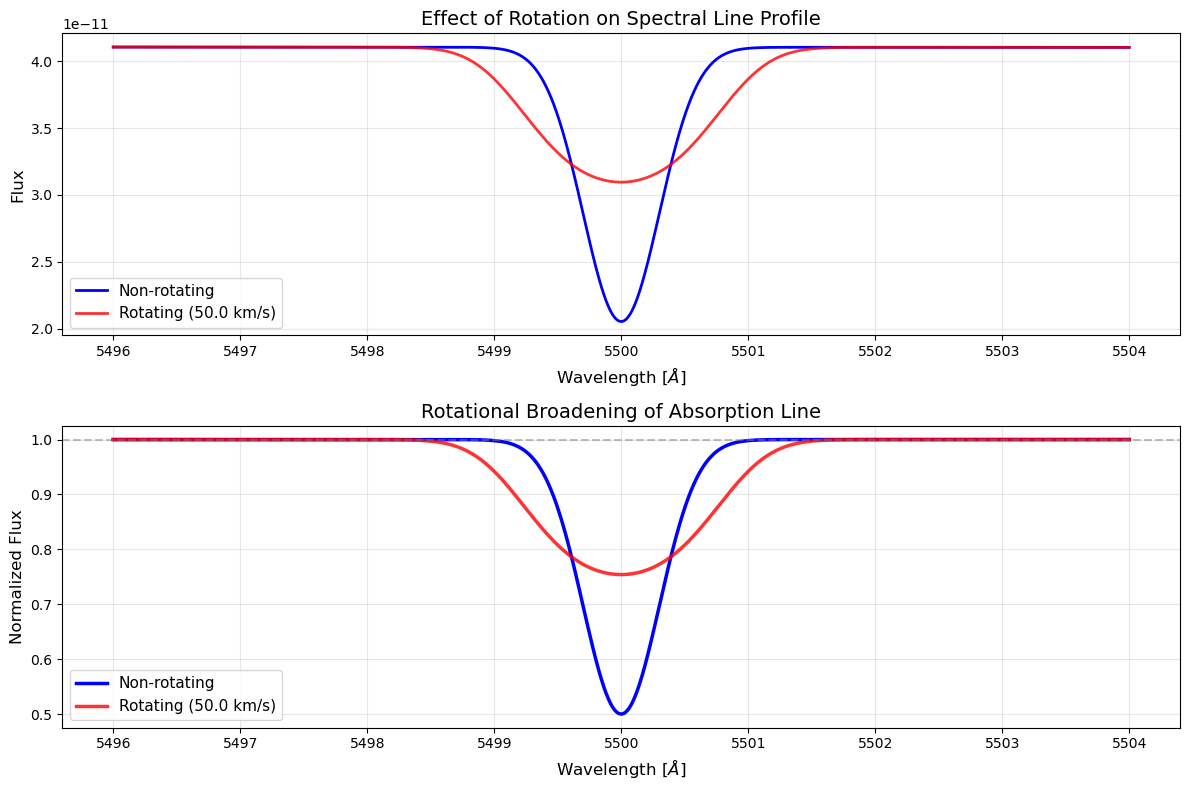

In [19]:
# Plot comparison
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

# Top: Flux comparison
ax1.plot(wavelengths_rot, spec_no_rot[:, 0], label='Non-rotating', 
         color='blue', linewidth=2)
ax1.plot(wavelengths_rot, spec_rot[:, 0], label=f'Rotating ({v_rot} km/s)', 
         color='red', linewidth=2, alpha=0.8)
ax1.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax1.set_ylabel('Flux', fontsize=12)
ax1.set_title('Effect of Rotation on Spectral Line Profile', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Bottom: Normalized comparison
norm_no_rot = spec_no_rot[:, 0] / spec_no_rot[:, 1]
norm_rot = spec_rot[:, 0] / spec_rot[:, 1]

ax2.plot(wavelengths_rot, norm_no_rot, label='Non-rotating', 
         color='blue', linewidth=2.5)
ax2.plot(wavelengths_rot, norm_rot, label=f'Rotating ({v_rot} km/s)', 
         color='red', linewidth=2.5, alpha=0.8)
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel(r'Wavelength [$\AA$]', fontsize=12)
ax2.set_ylabel('Normalized Flux', fontsize=12)
ax2.set_title('Rotational Broadening of Absorption Line', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Pulsation

In [33]:
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from tqdm import tqdm

pulsating_model = add_pulsation(base_model, m_order=4, l_degree=4, period=1,
                                fourier_series_parameters=np.array([[1., 1.]]))
timeseries = jnp.linspace(0, 1., 100)

mt_ps = [evaluate_pulsations(pulsating_model, t) for t in tqdm(timeseries, desc='Evaluating model with all parameters')]

Evaluating model with all parameters: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


In [34]:
spec_puls = np.array([simulate_observed_flux(
    emulator_star.intensity, pulsating_model, log_wavelengths_rot
) for pulsating_model in mt_ps])

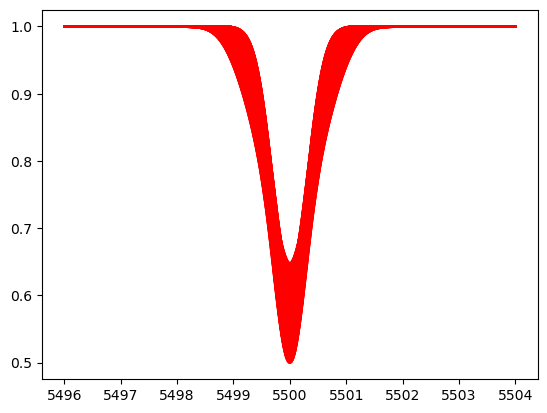

In [35]:
for sp in spec_puls:
    plt.plot(wavelengths_rot, sp[:, 0]/sp[:, 1], label='Pulsating', 
             color='red', linewidth=2)
plt.show()